<h1> Validate libNEST for S1S2 with LUX data, at 180 V/cm</h1>

In [1]:
from __future__ import division
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/LZ_git/fastNEST/libNEST') #add path to import Lib-NEST
import libNEST
import pandas as pd
import scipy.interpolate as ip
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

Populating the interactive namespace from numpy and matplotlib


<h1> Load in the Run03 LUX yields, from calibration data </h1>

In [3]:
CH3T_yield=loadtxt('data_yields/LUX_Dec2013_CH3T_Yields.txt',skiprows=1).T
DD_ly=loadtxt('data_yields/LUX_DD_LY.txt',skiprows=2).T
DD_qy=loadtxt('data_yields/LUX_DD_QY.txt',skiprows=2).T
LUX2013ER_yield=loadtxt('data_yields/LUX_ER_lines.txt',skiprows=1).T

<h1> Load in results from rootNEST.cc (latest LZ-git version)</h1>

In [4]:
rootNEST_ER_en=[1,2,3,4,5,6,7,8,10,15,30,50,90,100,200,300,500,600,900]
rootNEST_ER_LY=[]
rootNEST_ER_QY=[]

for en in rootNEST_ER_en:
    temp=loadtxt('data_yields/rootNEST_'+str(en)+'.txt',skiprows=1).T
    rootNEST_ER_LY.append(mean(temp[1])/mean(temp[0]))
    rootNEST_ER_QY.append(mean(temp[2])/mean(temp[0]))
    
#now for NR
rootNEST_NR_en=[1,2,5,10,30]
rootNEST_NR_LY=[]
rootNEST_NR_QY=[]

for en in rootNEST_NR_en:
    temp=loadtxt('data_yields/rootNEST_nr_'+str(en)+'.txt',skiprows=1).T
    rootNEST_NR_LY.append(mean(temp[1])/mean(temp[0]))
    rootNEST_NR_QY.append(mean(temp[2])/mean(temp[0]))

<h1> Get S1 S2 for tritium beta spectrum with LUX detector settings </h1>

<h3> Define a tritium beta spectrum, http://www.hindawi.com/journals/ahep/2013/293986/ </h3>

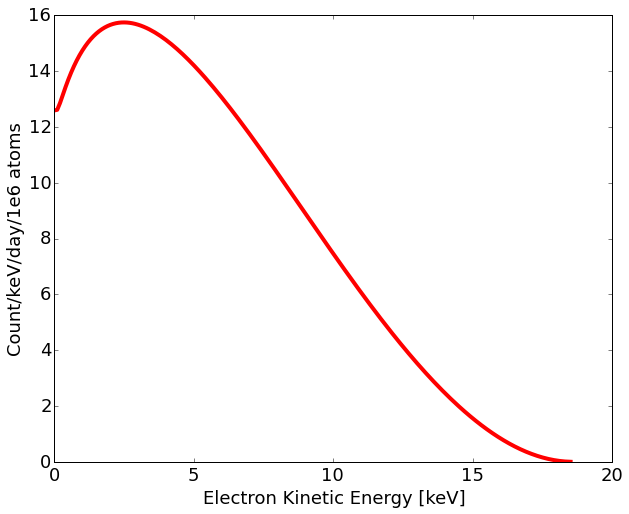

In [4]:
c=1;    # speed of light
C=1e-6; #constant infront of Fermi funciton. Arbitrary. Read Katrin paper if you care about super-allowed and allowed transitions... and nuclear matrix elements that don't matter
me = 511/c**2; # rest mass of our good friend the electron, in keV
Q=18.6 # endpoint of the tritium Beta decay keV. Maximum kinetic energy the electron.
mv=0   # neutrino mass=0. There may exist a 17 keV neutrino, maybe 7 keV!! Will we ever know??? Is it The Dark Matter?? Mystery...
step_T=0.1 #step energy by 0.1 keV
T=arange(0.01, 18.6,step_T) #sweep from 0.01 to the Q value in increments of step_T.
Z=1+1; #Tritium, after the beta decay Z'=1+1;
halflife = 12.32; # half life of the tritium beta decay in years
tau = 365*halflife/0.69; # Decay constant converted to days
n = 1e6; # Assume 1e6 atoms are decaying.
G=(T+me*c**2)/(me*c**2); #Gamma, Total energy(E+M^2) over M^2
B=sqrt((G**2-1)/G**2); # v/c of electron. Ratio of velocity to speed of light in vacuum.
x=(2*pi*Z/137)/B; # note: fine structure constant = 137. 
F_Kat=x*(1/(1-exp(-x))); # Katrin paper... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
KE=T; #(G-1).*me*c^2; % The kinetic energy, is equal to T
E=KE+me*c**2; # the total energy. KE + rest mass
P=sqrt(E**2-me**2*c**4)/c; # momentum of the electron
N=C*F_Kat*(KE+me)*sqrt((KE+me)**2-me**2)*(Q-KE)**2 # eqution 18 of Katrin paper. Set nutrino mass to zero... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
s = sum(N[~isnan(N)])*step_T # Total Counts
N = N * (1/s * n/tau) # Decays/keV/day/1e6 atoms

#plot to se beta spectrum for tritium 
figure(0)
plt.plot(T,N,'r',linewidth=4)
plt.xlabel('Electron Kinetic Energy [keV] ',fontsize=18)
plt.ylabel('Count/keV/day/1e6 atoms',fontsize=18)


<h3> Run beta spectrum through NEST and get S1 S2 responce to compare with LUX data </h3>

In [5]:
NEST=libNEST.NEST(1,100,180,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LUXSettings()
NEST.SetDetectorParameters(myDet)
LY=[]
QY=[]
Energy = logspace(-1,log10(1000),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)
    
#####
trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(tritium_beta[:,1]*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((tritium_beta[:,1].size,1));

gamma_T=np.ones((trials,1)); #  Tritium gamma spectrum
e_T=np.ones((trials,1));     #  Tritium electron spectrum.


kk=1; # kk will equal the total number of simulated tritium events

for jj in range(0, tritium_beta[:,0].size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(tritium_beta[jj,1]*trial_m)
    mean_gamma_T=tritium_beta[jj,2] # 2 for NESTv98 LY, 5 is with first fit to tritium.
    mean_e_T=tritium_beta[jj,3] # 3 for NESTv98 QY, 6 is with first fit to tritium.

    n_ion_T=(mean_gamma_T+mean_e_T)/(1+ex_to_ion_alpha);
    r_T=(mean_gamma_T/mean_e_T-ex_to_ion_alpha)/(mean_gamma_T/mean_e_T+1) #mean recombination fraction

    #Add functional form of recombination variance.%%%%%%%%%%%%%%%%%%% Cancels out in E space
    Recomb_V_T=(0.07*n_ion_T)**2;
    Fano_V=0; 

    for ii in range(0, subtrials[jj]-1):

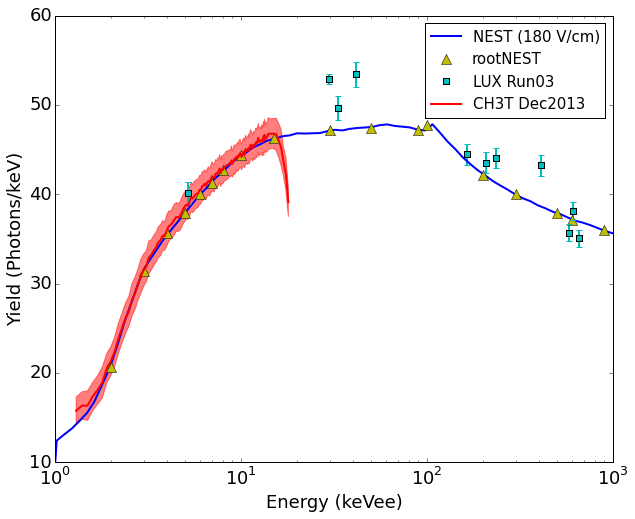

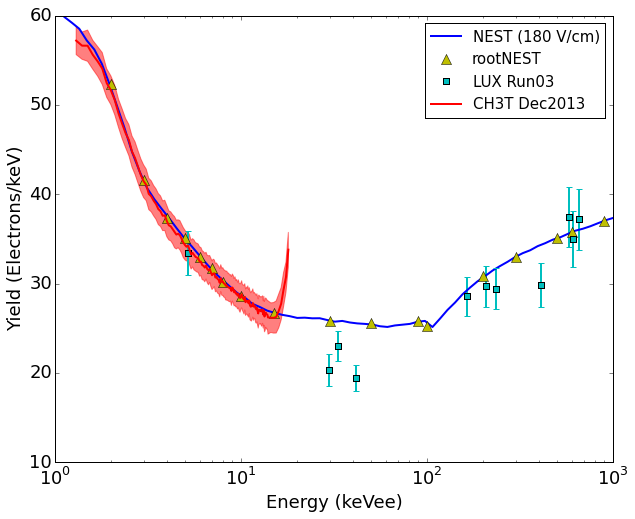

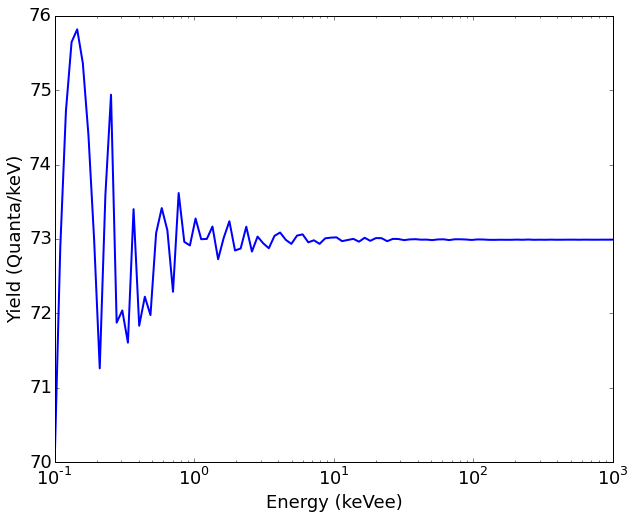

In [6]:
semilogx(Energy,LY,'-b',linewidth=2)
plt.plot(rootNEST_ER_en,rootNEST_ER_LY,'^y',linewidth=4,markersize=10)
plt.errorbar(LUX2013ER_yield[0],LUX2013ER_yield[1],LUX2013ER_yield[2],fmt="sc",markersize=6,linewidth=2,markeredgewidth=1) 
#plt.errorbar(CH3T_yield[0],CH3T_yield[2],sqrt(CH3T_yield[3]+CH3T_yield[4]),fmt=".r",markersize=5)
plt.fill_between(CH3T_yield[0], CH3T_yield[2]-sqrt(CH3T_yield[3]+CH3T_yield[4]), CH3T_yield[2]+sqrt(CH3T_yield[3]+CH3T_yield[4]),color='red',alpha=0.5)
plt.plot(CH3T_yield[0],CH3T_yield[2],'-r',linewidth=2)
xlabel('Energy (keVee)')
ylabel('Yield (Photons/keV)')
legend(['NEST (180 V/cm)','rootNEST','LUX Run03','CH3T Dec2013'],loc='upper right',fontsize=15,numpoints=1)
xlim([1,1000])
ylim([10,60])
plt.savefig('val_figs/LUX_ER_LY_val.png')

figure()
semilogx(Energy,QY,'-b',linewidth=2)
plt.plot(rootNEST_ER_en,rootNEST_ER_QY,'^y',linewidth=4,markersize=10)
plt.errorbar(LUX2013ER_yield[0],LUX2013ER_yield[3],LUX2013ER_yield[4],fmt="sc",markersize=6,linewidth=2,markeredgewidth=1) 
#plt.errorbar(CH3T_yield[0],CH3T_yield[2],sqrt(CH3T_yield[3]+CH3T_yield[4]),fmt=".r",markersize=5)
plt.fill_between(CH3T_yield[0], CH3T_yield[5]-sqrt(CH3T_yield[6]+CH3T_yield[7]), CH3T_yield[5]+sqrt(CH3T_yield[6]+CH3T_yield[7]),color='red',alpha=0.5)
plt.plot(CH3T_yield[0],CH3T_yield[5],'-r',linewidth=2)
xlabel('Energy (keVee)')
ylabel('Yield (Electrons/keV)')
legend(['NEST (180 V/cm)','rootNEST','LUX Run03','CH3T Dec2013'],loc='upper right',fontsize=15,numpoints=1)
xlim([1,1000])
ylim([10,60])
plt.savefig('val_figs/LUX_ER_QY_val.png')

figure()
semilogx(Energy,np.array(QY)+np.array(LY),'-b',linewidth=2)
xlabel('Energy (keVee)')
ylabel('Yield (Quanta/keV)')

In [8]:
#Save .txt file of E,LY,QY at LUX field for Evan
#savetxt('NEST_Yields/LUX_ER_TRD.txt',np.array([Energy,LY,QY]).T)

<h1> Calculate LY QY for NR and compare to DD data </h1>

In [7]:
NEST=libNEST.NEST(0,10,180,2.888) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LUXSettings()
NEST.SetDetectorParameters(myDet)

LY=[]
QY=[]
Energy = logspace(-1,log10(30),100)

for En in Energy:
    NEST.SetEnergy(En)
    LY_step=[]
    QY_step=[]
    for ii in arange(0,10000,1):
        NEST.DetectorResponse()
        LY_step.append(NEST.GetNumPhotons())
        QY_step.append(NEST.GetNumElectrons())
    LY.append(mean(np.array(LY_step))/En)
    QY.append(mean(np.array(QY_step))/En)

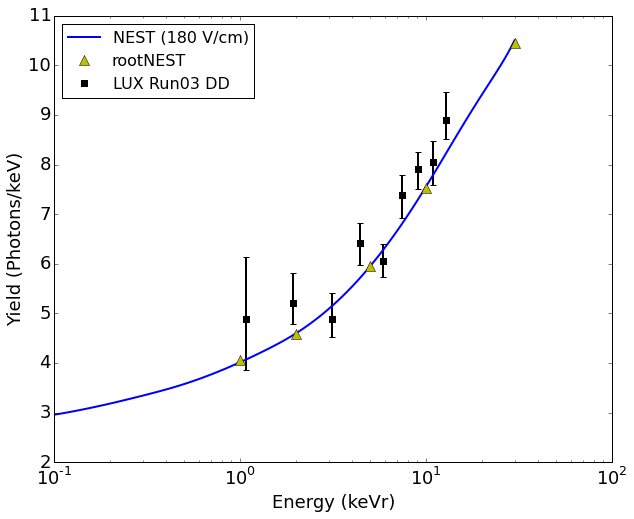

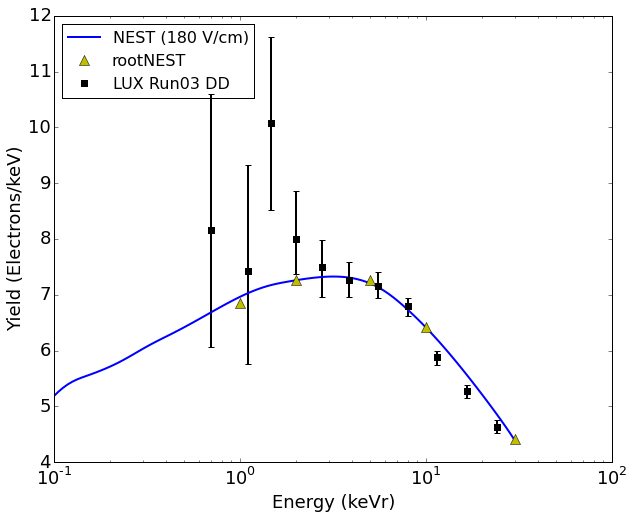

In [10]:
sLY = ip.UnivariateSpline(Energy, LY,s=.1)
semilogx(Energy,sLY(Energy),'-b',linewidth=2)
plt.plot(rootNEST_NR_en,rootNEST_NR_LY,'^y',linewidth=4,markersize=10)
plt.errorbar(DD_ly[0],DD_ly[4],[DD_ly[5],DD_ly[6]],fmt="sk",markersize=6,linewidth=2,markeredgewidth=1) 
xlabel('Energy (keVr)')
ylabel('Yield (Photons/keV)')
legend(['NEST (180 V/cm)','rootNEST','LUX Run03 DD'],loc='upper left',fontsize=16,numpoints=1)
#xlim([1,1000])
#ylim([10,60])
plt.savefig('val_figs/LUX_NR_LY_val.png')

#plot QY
figure()
sQY = ip.UnivariateSpline(Energy, QY,s=.1)
semilogx(Energy,sQY(Energy),'-b',linewidth=2)
plt.plot(rootNEST_NR_en,rootNEST_NR_QY,'^y',linewidth=4,markersize=10)
plt.errorbar(DD_qy[0],DD_qy[4],[DD_qy[5],DD_qy[6]],fmt="sk",markersize=6,linewidth=2,markeredgewidth=1) 
xlabel('Energy (keVr)')
ylabel('Yield (Electrons/keV)')
legend(['NEST (180 V/cm)','rootNEST','LUX Run03 DD'],loc='upper left',fontsize=16,numpoints=1)
plt.savefig('val_figs/LUX_NR_QY_val.png')

In [12]:
#Save .txt file of E,LY,QY at LUX field for Evan
#savetxt('NEST_Yields/LUX_NR_TRD.txt',np.array([Energy,LY,QY]).T)